# Comparison of spectrum between GIGATL outputs and Alitka Satellite 

Requisites :
 - git clone https://github.com/auraoupa/gonzag_cloud
 


In [1]:
import sys,os
from os import getenv
import warnings
warnings.filterwarnings("ignore")

In [2]:
GONZAG_DIR = '/home/jovyan/gonzag_cloud/gonzag' ; # get it there: https://github.com/brodeau/climporn
sys.path.append(GONZAG_DIR)
import gonzag as gz


## Params

For the model

In [3]:
model = 'GIGATL'
region = '1'
season = 'fma'
name_mod = model+'-Region'+region+'-'+season
name_ssh_mod = 'zeta'
name_lsm_mod = '_IsNotZero@salt' 
name_lat_mod = 'lat'
name_lon_mod = 'lon'
name_time_mod = 'ocean_time'
l_griddist = False
period_mod = ['2000-02-01','2000-04-30']

For altimetry data

In [4]:
name_sat= 'Altika'
tag_sat_catalog = 'al'
name_ssh_sat='sla_unfiltered'
name_time_sat='time'
period_sat = ['2014-02-01','2014-04-30'] #should cover the same period of a different year if needed

## Data

In [5]:
import xarray as xr
import intake
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

cat = intake.open_catalog('../SWOT-AdAC/catalog.yaml')
dsmod1 = cat[model](region=region,depth='surf', season=season).to_dask()

In [6]:
dsmod1

<xarray.Dataset>
Dimensions:     (eta_rho: 1489, eta_v: 1488, time: 2280, xi_rho: 1491, xi_u: 1490)
Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
Data variables: (12/13)
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
    lat         (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
    lon         (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
    ocean_time  (time) float32 dask.array<chunksize=(24,), meta=np.ndarray>
    ...          ...
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(1489, 1491), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 1489, 1491), meta=np.ndarray>
    temp        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 1489, 1491), meta=np.ndarray>
    u           (time, eta_rho, xi_u) float32 dask.array<chunksize=(24, 1489, 1490), meta=np.ndarray>
    v           (time, eta_v, xi_rho) float32 dask.array<chunksize=(24, 1488, 1491), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(24, 1489, 1491), meta=np.ndarray>

In [7]:
#get rid of 29th of february (2010 = leap year)
import numpy as nmp
from gonzag.io import GetTimeVector
from gonzag.utils import scan_idx
rvt = GetTimeVector( dsmod1, name_time_mod, lquiet=True )
(rtu1,rtu2)=nmp.array(['2000-02-29T00:00:00','2000-03-01T00:00:00'], dtype='datetime64')
jt1, jt2 = scan_idx( rvt, rtu1, rtu2 )
dsmod=dsmod1.drop_isel(time=nmp.arange(jt1,jt2+1,1))

In [8]:
from intake import open_catalog
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/altimetry.yaml")
dssat  = cat[tag_sat_catalog].to_dask()

In [9]:
dssat

<xarray.Dataset>
Dimensions:         (time: 34340107)
Coordinates:
    latitude        (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    longitude       (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
  * time            (time) datetime64[ns] 2013-03-14T05:44:50.445185 ... 2015...
Data variables:
    cycle           (time) int16 dask.array<chunksize=(34340107,), meta=np.ndarray>
    dac             (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    lwe             (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    mdt             (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    sla_filtered    (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    sla_unfiltered  (time) float64 dask.array<chunksize=(34340107,), meta=np.ndarray>
    track           (time) int16 dask.array<chunksize=(34340107,), meta=np.ndarray>
Attributes: (12/24)
    Conventions:               CF-1.6
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Swath
    comment:                   Sea surface height measured by altimeters refe...
    contact:                   servicedesk.cmems@mercator-ocean.eu
    creator_email:             servicedesk.cmems@mercator-ocean.eu
    ...                        ...
    software_version:          6.2_DUACS_DT2018_baseline
    source:                    Altika measurements
    ssalto_duacs_comment:      The reference mission used for the altimeter i...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    summary:                   SSALTO/DUACS Delayed-Time Level-3 sea surface ...
    title:                     DT Altika Global Ocean Along track SSALTO/DUAC...

## Model and Satellite objects

In [10]:
ModelGrid = gz.ModGrid( dsmod, period_mod, name_lon_mod, name_lat_mod , name_time_mod, dsmod, name_lsm_mod, distorded_grid=False )



 *** what we use to define model land-sea mask:
    => "_IsNotZero@salt" in dataset 

 *** Skipping computation of angle distortion of the model grid! ("-D" option not invoked)...

 *** About model gridded (source) domain:
     * shape =  (1489, 1491)
     * horizontal resolution:  0.007546403  degrees or  0.8384808350680396  km
     * Is this a global domain w.r.t longitude:  False
       ==> this is a regional domain
       ==> working in the [0:360] frame...
     * lon_min, lon_max =  279.15 298.04
     * lat_min, lat_max =  25.86 42.41
     * should we pay attention to possible STRONG local distorsion in the grid:  False
     * number of time records of interest for the interpolation to come:  2112
       ==> time record dates: 2000-02-01 to 2000-04-30, included



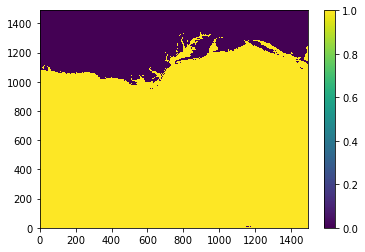

In [11]:
import matplotlib.pyplot as plt 
plt.pcolormesh(ModelGrid.mask)
plt.colorbar()


In [12]:
SatelliteTrack = gz.SatTrack( dssat, period_sat, name_time_sat, name_ssh_sat, domain_bounds=ModelGrid.domain_bounds, l_0_360=ModelGrid.l360 )

 *** [SatTrack()] Analyzing the time vector in dataset ...

 *** About satellite track (target) domain:
     * number of time records of interest for the interpolation to come:  29724
       ==> time record indices: 14883510 to 19033581, included

       separated in 154 tracks


## Process the tracks in parallel (results are saved in separate netcdf files)

In [13]:
if not os.path.exists('results_'+name_sat+'-'+name_mod):
        os.makedirs('results_'+name_sat+'-'+name_mod)

In [14]:
def process_one_track(track):
    tt = "{:02d}".format(track)
    Solution0 = gz.Model2SatTrack( ModelGrid, name_ssh_mod, SatelliteTrack, name_ssh_sat, track )
#    c1     = 'Model SSH interpolated in space (' ; c2=') and time on satellite track'
#    vvar   = [ 'latitude', 'longitude', name_ssh_mod+'_np'   , name_ssh_mod+'_bl' , name_ssh_sat          , 'distance'                            ]
#    vunits = [ 'deg.N'   , 'deg.E'    ,          'm'         ,     'm'            ,    'm'                ,    'km'                               ]
#    vlongN = [ 'Latitude', 'Longitude', c1+'nearest-point'+c2,  c1+'bilinear'+c2  , 'Input satellite data', 'Cumulated distance from first point' ]
#    from gonzag.config import rmissval
#    iw = gz.io.SaveTimeSeries( Solution0.time, \
#                             nmp.array( [Solution0.lat, Solution0.lon, Solution0.ssh_mod_np,
#                                         Solution0.ssh_mod, Solution0.ssh_sat, Solution0.distance] ), \
#                             vvar, 'results_'+name_sat+'-'+name_mod+'/result_'+str(tt)+'.nc', time_units='',\
#                             vunits=vunits, vlnm=vlongN, missing_val=rmissval )
    return Solution0


In [15]:
track=0
sol0=process_one_track(track)

In [ ]:
sol0.

In [17]:
sol0.ssh_mod_np

masked_array(data=[0.69715887, 0.6971879 , 0.69721687, 0.6972459 ,
                   0.69727492, 0.69730389, 0.69733292, 0.69736195,
                   0.69739091, 0.69741994, 0.69744897, 0.69782603,
                   0.69785506, 0.69788402, 0.69791305, 0.69794208,
                   0.69797105, 0.69800007, 0.6980291 , 0.69805807,
                   0.6980871 , 0.69811606, 0.69814509, 0.69817412,
                   0.69820309, 0.69823211, 0.69826114, 0.69829011,
                   0.69831914, 0.69834816, 0.69837713, 0.69840616,
                   0.69843519, 0.69846416, 0.69849318, 0.69852221,
                   0.69855118, 0.69858021, 0.69860923, 0.6986382 ,
                   0.69866723, 0.6986962 , 0.69872522, 0.69875425,
                   0.69878322, 0.69881225, 0.69884127, 0.69887024,
                   0.69889927, 0.6989283 , 0.69895726, 0.69898629,
                   0.69901532, 0.69904429, 0.69907331, 0.69910228,
                   0.69913131, 0.69916034, 0.69918931, 0.69921

In [19]:
import xarray as xr
import sys
import glob
import numpy as nmp
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

%matplotlib inline


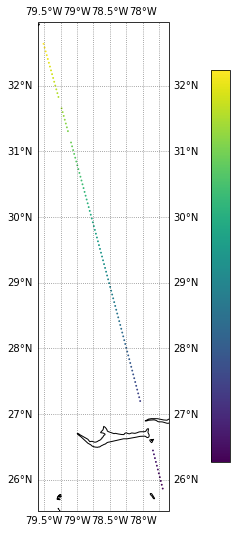

In [25]:
fig = plt.figure(num = 1, figsize=(15,9), facecolor='w', edgecolor='k')
ax = plt.subplot(111,projection=ccrs.PlateCarree())
#ax.set_extent((-82, -60, 25, 43))
ax.coastlines(resolution="10m")
#ax.set_xticks(nmp.arange(-80,30,1.5), crs=ccrs.PlateCarree())
#ax.set_xticklabels(nmp.arange(-80,30,1.5))
#ax.set_yticks(nmp.arange(-50,50,1.5), crs=ccrs.PlateCarree())
#ax.set_yticklabels(nmp.arange(-50,50,1.5))

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                          alpha=0.5)

idx = sol0.lon
idy = sol0.lat
t = sol0.time
cf = ax.scatter(idx, idy, c=t, cmap = 'viridis', marker='.', s=3 )
    
cbar = plt.colorbar(cf,shrink=0.8)
cbar.set_ticks([])


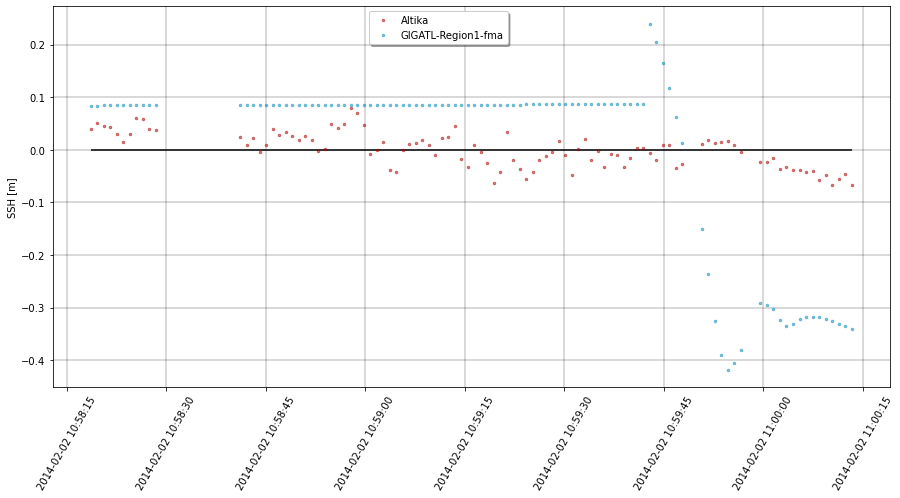

In [27]:
del fig,ax
clr_sat = '#AD0000'
clr_mod = '#008ab8'

VT = sol0.time ; 

fig = plt.figure(num = 1, figsize=(15,7), facecolor='w', edgecolor='k')
ax = plt.subplot(111)
plt.hlines(0,nmp.min(sol0.time),nmp.max(sol0.time), colors='k',label=None,  zorder=5)
plt.plot(VT, sol0.ssh_sat-nmp.mean(sol0.ssh_sat), '.', color=clr_sat, markersize=5, 
         alpha=0.5, label=name_sat, zorder=10)
plt.plot(VT, sol0.ssh_mod-nmp.mean(sol0.ssh_mod), '.', color=clr_mod, markersize=5, 
         alpha=0.5, label=name_mod, zorder=15)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation='60')
plt.ylabel('SSH [m]')
ax.grid(color='k', linestyle='-', linewidth=0.3)
lgnd = plt.legend(bbox_to_anchor=(0.55, 1.), ncol=1, shadow=True, fancybox=True)

